In [2]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import RANSACRegressor
from sklearn.ensemble import RandomForestRegressor 
from yellowbrick.model_selection import LearningCurve
from yellowbrick.features import Rank1D
from yellowbrick.regressor import ResidualsPlot

from MLDA.miscellaneous.save_and_load_files import load_object, save_object
from MLDA.ML_functions.ML_dict import splitDataAndAddToMLDict, addFeatImpToDict
from MLDA.plot_functions.model_visual import showFeatureImportanceForModels, showResidualsForModels, showLearningCurveForModels;

### The relevant columns are selected

In [3]:
# First we load the cleaned data from the DA_module
da_dict = load_object(
    '/home/jesper/Work/MLDA_app/MLDA/jupyter_DA/da_dict_N1.sav')

data = da_dict["data"]

"""Choosing vars for ML_dict"""
# Still pandas
xdata = data.iloc[:, 1:-2]  # Selecting all x except 'rel_compact'
ydata = data.iloc[:, -2:]  # Selecting all y
# print(xdata)

xdata = xdata.loc[:, xdata.columns != "orientation"]  # Excluding 'orientation'
models = ["ransac", "forest"]


# Below here we init the ML_dict we want to use
ML_dictEN1 = {}  # Energy dict excluding the two vars: 'rel_compact' and 'orientation'. ID is: xcols: [0, 1, 2, 3, 4, 5]_ycols: [0, 1]_['ransac', 'forest']_test_size: 0.2
test_size = 0.2


ML_dictEN1,type_ = splitDataAndAddToMLDict(
    df_xdata=xdata, df_ydata=ydata, ML_dict=ML_dictEN1, models=models, test_size=test_size
)

"""END Choosing vars for ML_dict"""


'END Choosing vars for ML_dict'

### Info about DA_dict and ML_dict structure below here

In [4]:
"""ML_dict structure"""
# ML_dict_Name1 = {'id': "xcols: [0, 1, 2, 3, 4, 5]_ycols: [0, 1]_['ransac', 'forest']_test_size: 0.2",
#                           'df_data': {dataframe with xdata and ydata}
#                           'xdata_names':
#                           'X': {'X_train': np.arrays
#                                 'X_test': np.arrays}
#                           'models': {'names': ['ransac', 'forest']} example
#                           'Y': {'yname1': {'pred':{'ransac': {'train': np.arrays, 'test': np.arrays, 'predictor': None, 'pred_object': RANSACRegressor(), 'MSE': value, 'R2': value}
#                                                    'forest': {'train': np.arrays, 'test': np.arrays, 'predictor': None, 'pred_object': RandomForestRegressor() ,'MSE': value, 'R2': value}}
#                                            'actual': {'train': np.arrays, 'test': np.arrays}}
#                                {'yname2': {'pred':{'ransac': {'train': np.arrays, 'test': np.arrays, 'predictor: None', 'MSE': value, 'R2': value}
#                                                    'forest': {'train': np.arrays, 'test': np.arrays, 'predictor: None', 'MSE': value, 'R2': value}}
#                                            'actual': {'train': np.arrays, 'test': np.arrays}}}}
#     }
"""END ML_dict structure"""

"""DA_dict structure"""

# da_dict structure
# da_dict = {'id_label': "CATCOLS: [] - NUMCOLS: ['rel_compact', 'surf_area', 'wall_area', 'roof_area', 'height', 'orientation', 'glazing_area', 'glaz_area_distrib', 'heat_load', 'cool_load'] - CI: 0.1 - METHOD_CC: Asym - METHOD_CN: Omega - METHOD_NN: Spearmann",
#            'data': df,
#            'correlation' df_corr,
#            'p-values': df_p}

"""END DA_dict structure"""

# For more info: /home/jesper/Work/MLDA_app/MLDA/ML_functions/ML_dict.py

'END DA_dict structure'

### Below here ALL xdata columns are used

### Train predictors and add to ML_dict

In [5]:
def trainPredictor(predictor, X_train=None, Y_train=None):
    """Input: predictor: string, e.g.: 'forest' or 'ransac'"""
    if predictor=='ransac':
        pred_object = RANSACRegressor()
        model = RANSACRegressor(min_samples=50, random_state=0) 
        model.fit(X_train, Y_train) 
    elif predictor=='forest':
        pred_object = RandomForestRegressor()
        model = RandomForestRegressor(n_estimators=1000, criterion='mse') 
        model.fit(X_train, Y_train)
    return model, pred_object


def addPredictorAndPredictionToMLDict(ML_dict=None):
    """Adding only one 'name' from ML_dict at a time. But all ydata_names and all models pre-
    dictors are added for each call of the function"""
    models = ML_dict["models"]
    y_names = ML_dict["ydata_names"]
    X_train = ML_dict["X"]["X_train"]
    X_test = ML_dict["X"]["X_test"]
    test = []
    for y_name in y_names:
        Y_train = ML_dict["Y"][y_name]["actual"]["train"]
        for model in models:
            predictor, pred_object = trainPredictor(
                predictor=model, X_train=X_train, Y_train=Y_train
            )
            # Adding predictor and pred_object to dict
            ML_dict["Y"][y_name]["pred"][model]["predictor"] = predictor
            ML_dict["Y"][y_name]["pred"][model]["pred_object"] = pred_object
            # Adding prediction to dict - both train and test
            ML_dict["Y"][y_name]["pred"][model]["train"] = predictor.predict(X_train)
            ML_dict["Y"][y_name]["pred"][model]["test"] = predictor.predict(X_test)

    return ML_dict

ML_dict = addPredictorAndPredictionToMLDict(ML_dict=ML_dictEN1)

# Store ML_dict
# save_object(ML_dictEN1, 'ML_dictEN1') # comment out when stored... stores as 'ML_dict.sav'

# ML_dictEN1

### Adding feature importance to ML_dict

In [6]:
ML_dictEN1=load_object('ML_dictEN1.sav')

# addFeatImpToDict(ML_dict=ML_dictEN1)
# save_object(ML_dictEN1, 'ML_dictEN1') # comment out when stored... stores as 'ML_dict.sav'

### Showing feature importance, Residuals and Learning Curve

/home/jesper/Work/MLDA_app/MLDA/plot_functions/model_visual.py:775: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



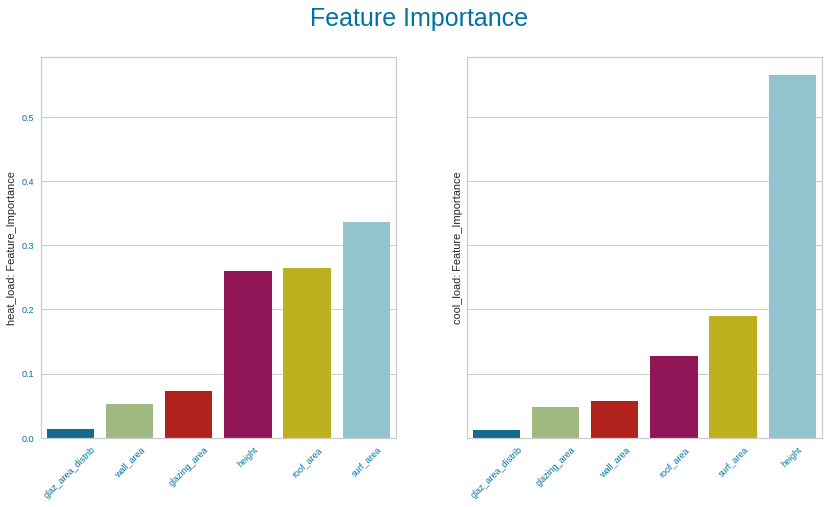

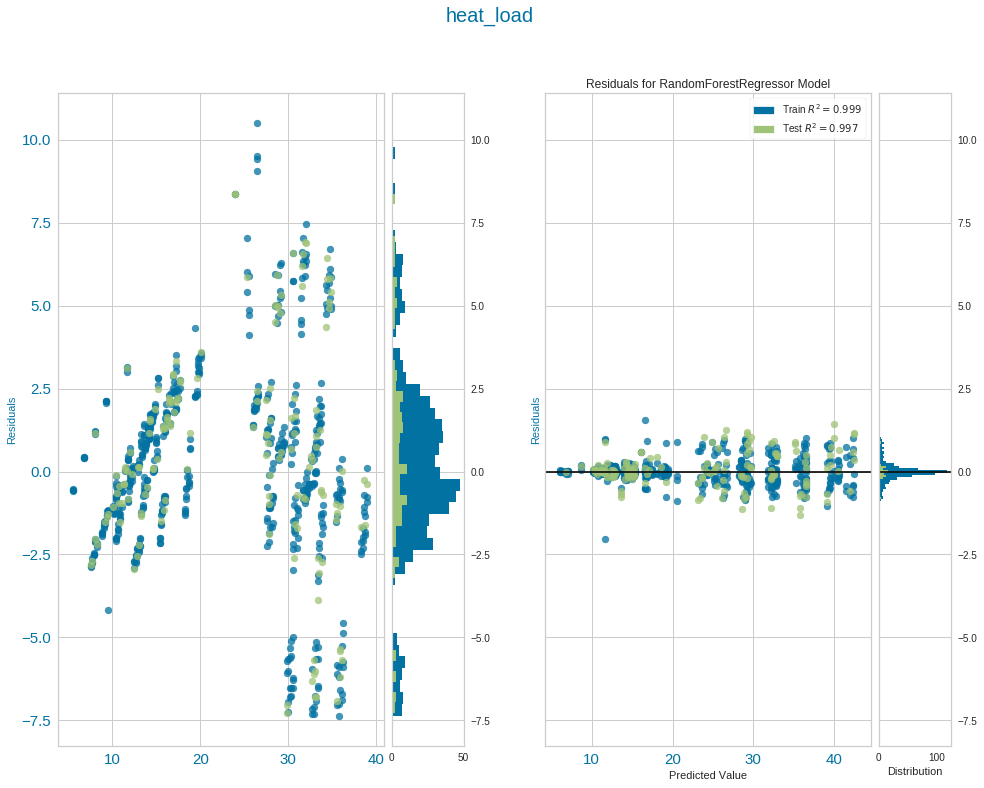

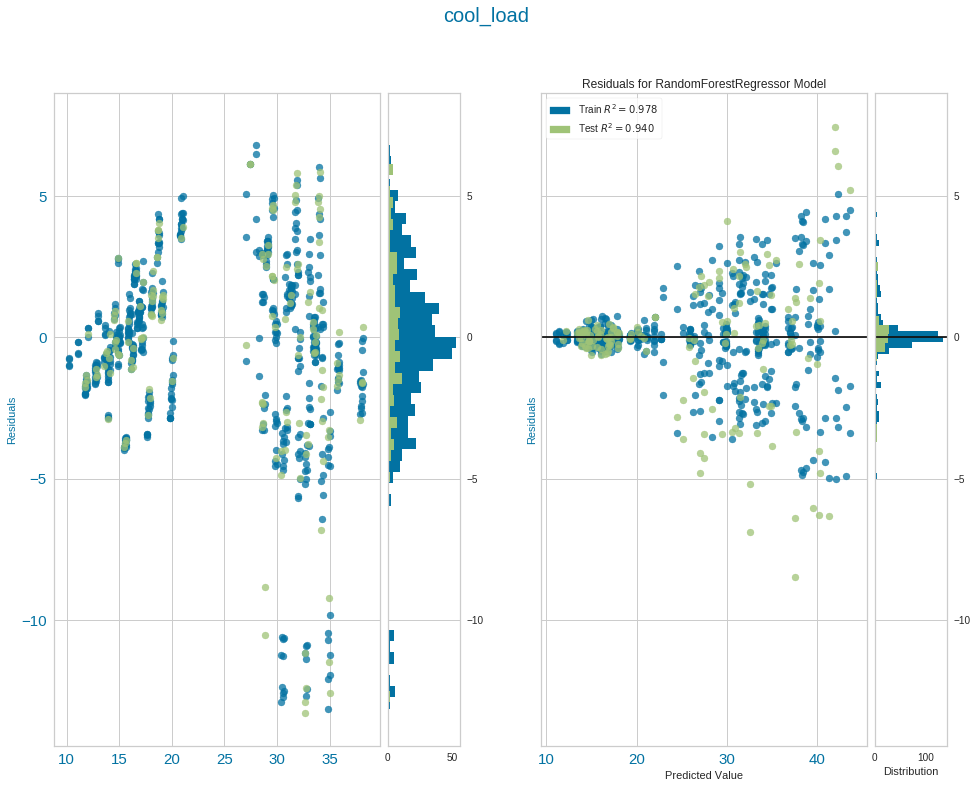

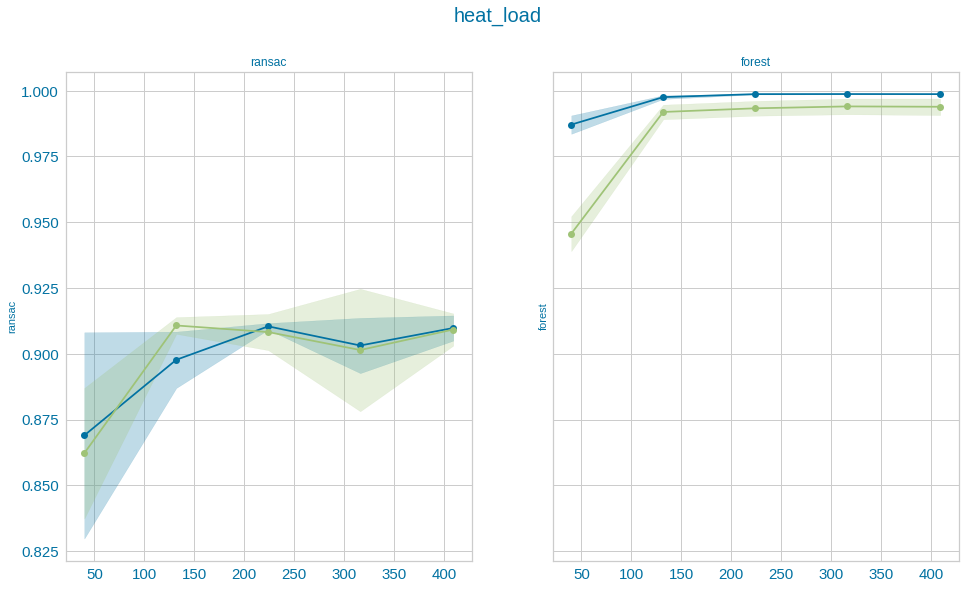

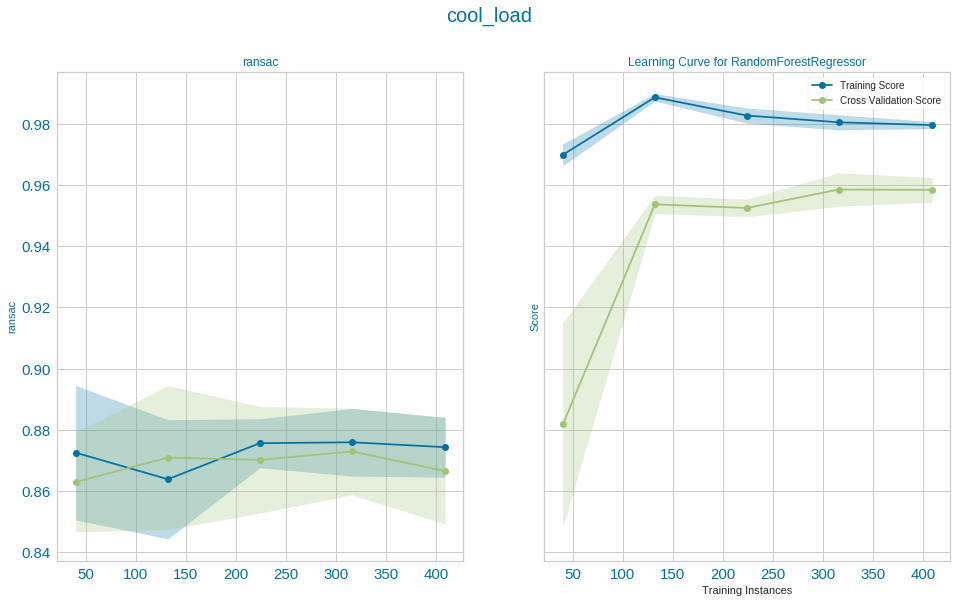

In [7]:
ML_dictEN1=load_object('ML_dictEN1.sav')
showFeatureImportanceForModels(ML_dict=ML_dictEN1)
showResidualsForModels(ML_dict=ML_dictEN1)
showLearningCurveForModels(ML_dict=ML_dictEN1)

# Predictions

Approach: model for prediction is either ransac or forest.
1) model is ransac: we predict using ransac predictor (lin regr)
2) model is forest: a) based on values for prediction (indep vars) and factor we find closest_lower and closest_higher in the train data: to_predict = {'x1': [4, 6], 'x2': [14, 16], 'x3': [7, 7], .......} , note that for 'x3' closest_lower and closest_higher are equal. That's because 

In [9]:
# predict = [1,400,47,44]

# if model == 'ransac':
#     predict = ransac

# if model == 'forest':


### Preparing data in order to find our model's min or max using scipy.optimize

In [12]:
from scipy import optimize as opt

print(xdata)
# first we match up the names of the variables with its place/index in X
x_id = {}
for num, name in enumerate(xdata.columns):
    x_id['index'+str(num)] = name
# So if you want to know name of third var in X, type: x_id['X2']
# print(x_id['X2']) # This gives X4
print(x_id)
# calculate min/max of all items in X

bounds = []
x0 = []
for key in x_id.keys():
    bounds.append((xdata[x_id[key]].min(), xdata[x_id[key]].max()))
    x0.append(xdata[x_id[key]].mean())
print(bounds)
print(x0)

rranges = []

def generateSlices():
    '''Adjust the values in 'slices' and 'col_num_slice_val'. Then it generates slices'''
    
    # Size of the slices
    slices = {
        'slice1': 30,
        'slice2': 1.5,
        'slice3': .15,
    }

    # Select which column should have which slice - counting the colums from left to right, starting with 0.
    col_num_slice_val = {
        'slice1': [0,1,2], 
        'slice2': [3,5],
        'slice3': [4],
    } 
    
    # Generate empty list with length equal to number of columns
    x_slices = [None] * len(xdata.columns)

    # Use both's dict above to create the slices
    for key in col_num_slice_val.keys():
        for col in col_num_slice_val[key]:
            x_slices[col] = slices[key]
    return x_slices


x_slices = generateSlices()
print(x_slices)

def calcArraySize():
    array_size = 1
    for x, xslice in zip(bounds, x_slices):
        array_size *= math.ceil((x[1] - x[0])/xslice)
    return array_size
print('calcArraySize:', calcArraySize())

'''Create the "rranges" to be used in "opt.brute"'''
for x, xslice in zip(bounds, x_slices):
    rranges.append(slice(x[0], x[1], xslice))

print(rranges)
def f(x):
    return forest.predict(x.reshape(1,-1))

# ux_brute = opt.brute(f, rranges, full_output=True, finish=None) # comment out when runned

"""Saving the ux_brute"""

# obj_uxbrute = save_object(ux_brute, 'ux_brute') # comment out when saved

     surf_area  wall_area  roof_area  height  glazing_area  glaz_area_distrib
0        514.5      294.0     110.25     7.0           0.0                  0
1        514.5      294.0     110.25     7.0           0.0                  0
2        514.5      294.0     110.25     7.0           0.0                  0
3        514.5      294.0     110.25     7.0           0.0                  0
4        563.5      318.5     122.50     7.0           0.0                  0
..         ...        ...        ...     ...           ...                ...
763      784.0      343.0     220.50     3.5           0.4                  5
764      808.5      367.5     220.50     3.5           0.4                  5
765      808.5      367.5     220.50     3.5           0.4                  5
766      808.5      367.5     220.50     3.5           0.4                  5
767      808.5      367.5     220.50     3.5           0.4                  5

[768 rows x 6 columns]
{'index0': 'surf_area', 'index1': 'wall_

'Saving the ux_brute'

In [11]:
"""Loading the ux_brute"""

ux_brute = load_object(
    '/home/jesper/Work/MLDA_app/MLDA/jupyter_ML/ux_brute.sav')

print('ux_brute[0]:', ux_brute[0])
print('ux_brute[1]', ux_brute[1])

ux_brute[0]: [694.5  245.   200.25   3.5    0.     0.  ]
ux_brute[1] 6.048751821067831


In [ ]:
from MLDA.plot_functions.model_visual import xyZ_forSurfaceplot, surfacePlotly, forAnimationPlot, plotlyAnimation, validationPlot,findVarsForPlot

# Loading data
data = load_object(
    "/home/jesper/Work/MLDA_app/MLDA/jupyter_DA/energy_data.sav")
xdata = data.iloc[:, 1:-2]

# Loading random forest regressor
rf_regressor = load_object(
    "/home/jesper/Work/MLDA_app/MLDA/jupyter_ML/forest_saved.sav")

# Functions
def f(x):
    if len(x.shape) == 1:
        x = x.reshape(1, -1)
    return rf_regressor.predict(x)


opt_values = [674.5, 245.0, 190.25, 3.5, 4.0, 0.0, 0.0]
bounds = [
    (514.5, 808.5),
    (245.0, 416.5),
    (110.25, 220.5),
    (3.5, 7.0),
    (2, 5),
    (0.0, 0.4),
    (0, 5),
]
# most important features: x5, x2, x4

# Dict's for optimal values and bounds
names_and_opt_values = {
    name: value
    for name, value in zip(xdata.columns, opt_values)
}
# print

In [ ]:
from MLDA.plot_functions.model_visual import xyZ_forSurfaceplot, surfacePlotly, forAnimationPlot, plotlyAnimation, validationPlot

# Loading data
data = load_object(
    "/home/jesper/Work/MLDA_app/MLDA/jupyter_DA/energy_data.sav")
xdata = data.iloc[:, 1:-2]

# Loading random forest regressor
rf_regressor = load_object(
    "/home/jesper/Work/MLDA_app/MLDA/jupyter_ML/forest_saved.sav")


# Functions
def f(x):
    if len(x.shape) == 1:
        x = x.reshape(1, -1)
    return rf_regressor.predict(x)

print(f(np.array([674.5, 245.0, 190.25, 3.5, 4.0, 0.0, 0.0])))
opt_values = [674.5, 245.0, 190.25, 3.5, 4.0, 0.0, 0.0]
bounds = [
    (514.5, 808.5),
    (245.0, 416.5),
    (110.25, 220.5),
    (3.5, 7.0),
    (2, 5),
    (0.0, 0.4),
    (0, 5),
]

# Automatic selection of most relevant variables to plot
da_dict = load_object(
    '/home/jesper/Work/MLDA_app/MLDA/jupyter_DA/da_dict_N1.sav')
ml_dict = load_object('train_test_dict.sav')
num_for_plot = 3
xdata_names=ml_dict['N1']['xdata_names']
xdata_numpy=ml_dict['N1']['X']['x_train']

level = .5
df_corr, df_feat_imp = da_dict['correlation'], ml_dict["N1"]["Y"]["heat_load"]["pred"]["forest"]["df_feat_imp"]
vars_to_plot=findVarsForPlot(num_for_plot=num_for_plot, xdata_names=xdata_names, df_corr=df_corr, df_feat_imp=df_feat_imp, level=level)
# print(vars_to_plot)

x, y, frame_var = vars_to_plot['var1'], vars_to_plot['var2'], vars_to_plot['var3']
# x_steps, y_steps, num_frames = 30, 30, 30

# Predictor
# 'Y': {'yname1': {'pred':{'ransac': {'train': np.arrays, 'test': np.arrays, 'predictor'
predictor = ml_dict['N1']['Y']['heat_load']['pred']['forest']['predictor']
# print(predictor)
# Dict's for optimal values and bounds
names_and_opt_values = {
    name: value
    for name, value in zip(xdata.columns, opt_values)
}
# print(names_and_opt_values)

names_and_bounds = {name: value for name, value in zip(xdata.columns, bounds)}



def forAnimationPlot(
    predictor=predictor
    dict_namesbounds=names_and_bounds,
    dict_namesvalues=names_and_opt_values,
    df_xdata=,
    xvar_str=None,
    yvar_str=None,
    frame_var_str=None,
    reshape_transpose=True,
)



# predictor = f
# x_lin, y_lin, Z = xyZ_forSurfaceplot(predictor=f,
#                                      dict_namesbounds=names_and_bounds,
#                                      dict_namesvalues=names_and_opt_values,
#                                      xdata=xdata,
#                                      x=x,
#                                      y=y,
#                                      x_steps=x_steps,
#                                      y_steps=y_steps,
#                                      reshape_transpose=True)

# surfacePlotly(
#     x_points=x_points,
#     y_points=y_points,
#     Z_array=Z,
#     xvar_str="height",
#     yvar_str="roof_area",
#     x_opt=(3.5,),
#     y_opt=(220.5,),
#     z_opt=(6.048,),
# )

# # old surfacePlotly(x=x, y=y, z=Z, x_lin=x_lin, y_lin=y_lin)

# x_lin, y_lin, var_lin, Z_dict = forAnimationPlot(
#     predictor=f,
#     dict_namesbounds=names_and_bounds,
#     dict_namesvalues=names_and_opt_values,
#     xdata=xdata,
#     x=x,
#     y=y,
#     x_steps=x_steps,
#     y_steps=y_steps,
#     frame_var=frame_var,
#     num_frames=num_frames,
#     reshape_transpose=True)

# plotlyAnimation(x=x,
#                 y=y,
#                 frame_var=frame_var,
#                 x_lin=x_lin,
#                 y_lin=y_lin,
#                 var_lin=var_lin,
#                 Z_dict=Z_dict)

# validationPlot(vars=[x, y, frame_var],
#                steps=[20, 20, 20],
#                xdata=xdata,
#                dict_namesvalues=names_and_opt_values,
#                dict_namesbounds=names_and_bounds,
#                levels=[0, .3, .7, 1],
#                level_vars=[x, y],
#                predictor=f)